# Lingolino Refactored
This notebook uses the refactored module structure for better code organization.


In [1]:
# Import required libraries
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver

# Import our custom modules
from states import State, BackgroundState
from immediate_graph import create_immediate_response_graph, set_config as set_immediate_config
from background_graph import create_background_analysis_graph
from nodes import set_background_graph


In [2]:
# Load environment variables
load_dotenv()


True

In [3]:
# Initialize LLM and memory
llm = init_chat_model("google_genai:gemini-2.0-flash")
memory = MemorySaver()


E0000 00:00:1760543351.858806  745989 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
# Create the graphs
# Note: We need to create background graph first, then pass it to immediate graph
background_graph = create_background_analysis_graph(llm, memory)

# Set the background graph reference for cross-graph communication
set_background_graph(background_graph)

# Now create the immediate graph with reference to background graph
immediate_graph = create_immediate_response_graph(llm, memory, background_graph)

print("Graphs created successfully!")


Graphs created successfully!


=== Immediate Response Graph ===
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	initialStateLoader(initialStateLoader)
	load_analysis(load_analysis)
	masterChatbot(masterChatbot)
	format_response(format_response)
	__end__(<p>__end__</p>)
	__start__ -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



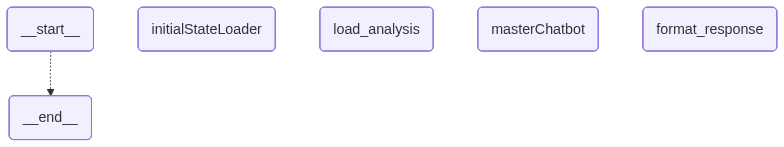


=== Background Analysis Graph ===
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__(<p>__start__</p>)
	initialStateLoader(initialStateLoader)
	educationalWorker(educationalWorker)
	storytellingWorker(storytellingWorker)
	__end__(<p>__end__</p>)
	__start__ -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



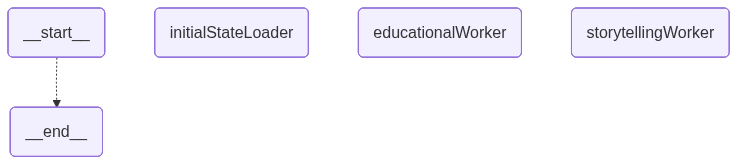

In [5]:
# Visualize the graphs
from IPython.display import Image, display

print("=== Immediate Response Graph ===")
print(immediate_graph.get_graph().draw_mermaid())
display(Image(immediate_graph.get_graph().draw_mermaid_png()))

print("\n=== Background Analysis Graph ===")
print(background_graph.get_graph().draw_mermaid())
display(Image(background_graph.get_graph().draw_mermaid_png()))


In [6]:
# Simulation of first interaction
config = {'configurable': {'thread_id': '9'}}
set_immediate_config(config)

state = immediate_graph.invoke({
    "messages": [{"role": "user", "content": "Start"}],
    "child_id": "2",
    "game_id": "0",
}, config=config)

print("======== Final response ========")
print(state["messages"][-1].content)


Game loaded: Du bist Lino, ein Teddybär und Erklärbär. Ein Erklärbar ist ganz schlau und kann Kindern ganz viele Sachen erklären. Immer wenn ein Kind eine Frage hat, kann das Kind mit der Frage zu dir kommen. Dann schaut ihr gemeinsam, ob ihr die Frage beantworten könnt.
Child profile loaded: Das Kind ist 8 Jahre alt, mag Fussball und Videospiele. Es liest gerne Abenteuerbücher.
======== Final response ========
Hey there, future explorer! Ready for an adventure? Tell me, what amazing things are you curious about today?


In [7]:
# Async processing function
import asyncio

async def process_user_input(user_input, config):
    """
    Process user input with immediate response and background analysis.
    
    :param user_input: User input message
    :param config: Configuration with thread_id
    :return: Immediate response result
    """
    # Immediate response task
    immediate_task = asyncio.create_task(
        immediate_graph.ainvoke(user_input, config)
    )
    
    # Wait for the immediate response
    immediate_result = await immediate_task
    
    # Start the background analysis after the immediate response
    background_input = {
        "child_profile": immediate_result["child_profile"],
        "game_description": immediate_result["game_description"],
        "messages": immediate_result["messages"],
    }
    background_config = {
        "configurable": {
            "thread_id": config["configurable"]["thread_id"] + "_analysis"
        }
    }
    background_task = asyncio.create_task(
        background_graph.ainvoke(background_input, background_config)
    )
    
    # Background task runs in background (Fire & Forget)
    # No await - continues running in background
    
    return immediate_result


In [11]:
# Interactive chat session
config = {'configurable': {'thread_id': '9'}}
in_message = input("You: ")

try:
    result = await process_user_input({"messages": [{"role": "user", "content": in_message}]}, config)
except SyntaxError:
    result = asyncio.run(process_user_input({"messages": [{"role": "user", "content": in_message}]}, config))

print(result["messages"][-1].content)


Okay explorer, let's leave no stone unturned. You and Lino start searching every corner of the football field.

You check behind the goalposts first. Nothing but a few lost water bottles and some very enthusiastic ants.

Then, you and Lino search the sidelines, carefully peeking under the benches where the football players sit. You find some old candy wrappers and a very surprised looking frog, but still no sign of the football.

You even search the groundskeeper's shed, but all you find are lawnmowers and bags of fertilizer. Whew, that was a stinky adventure.

After searching high and low, it seems the football field is not where the ball is.

Lino looks a little disappointed, but then you remember the muddy map. Maybe that's the best clue we have.

Do you want to go back to the center of the field and try to order the places on the map, or do you have another idea where Lino might have hidden the football?
